# Vehicle Detection Project

The steps of this project are the following:


* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images.

* Apply a color transform and append binned color features, as well as histograms of color, to the HOG feature vector.

* Normalize the features and randomize a selection for training and testing.

* Train a Linear SVM classifier.

* Implement a sliding-window technique and use the trained classifier to search for vehicles in images.

* Run the pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

* Estimate a bounding box for vehicles detected.

---


## Step 0. Feature Functions and Parameter Preparing

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog

#### Histogram of Oriented Gradients (HOG) features extraction:

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        
        return features

#### Color histogram features extraction:

In [3]:
# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 1)): # reading *.png files from training data with mpimg
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    return hist_features

#### Binned color features extraction:

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    
    return features

#### Concatenate HOG, color histogram, and bin spatial features:

In [5]:
# Define a function to extract features from a list of images with calling bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))

    return features

#### Tweak these parameters:

In [6]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

## Step 1. HOG feature extractionon on a labeled training set of images

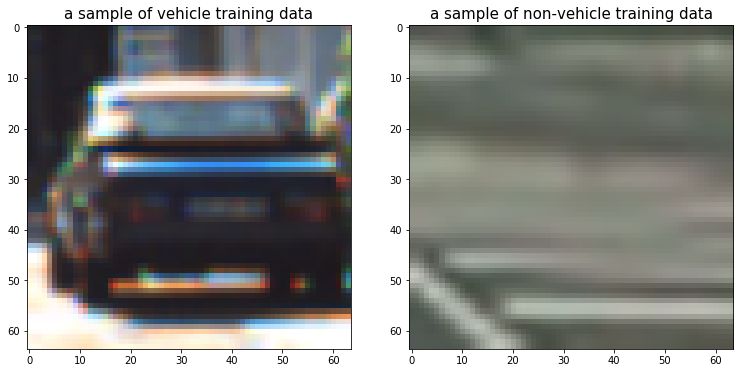

In [7]:
v_image = mpimg.imread('./examples/vehicle_samples/5.png')
nv_image = mpimg.imread('./examples/non_vehicle_samples/5.png')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()
ax1.imshow(v_image)
ax1.set_title('a sample of vehicle training data', fontsize=15)
ax2.imshow(nv_image)
ax2.set_title('a sample of non-vehicle training data', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

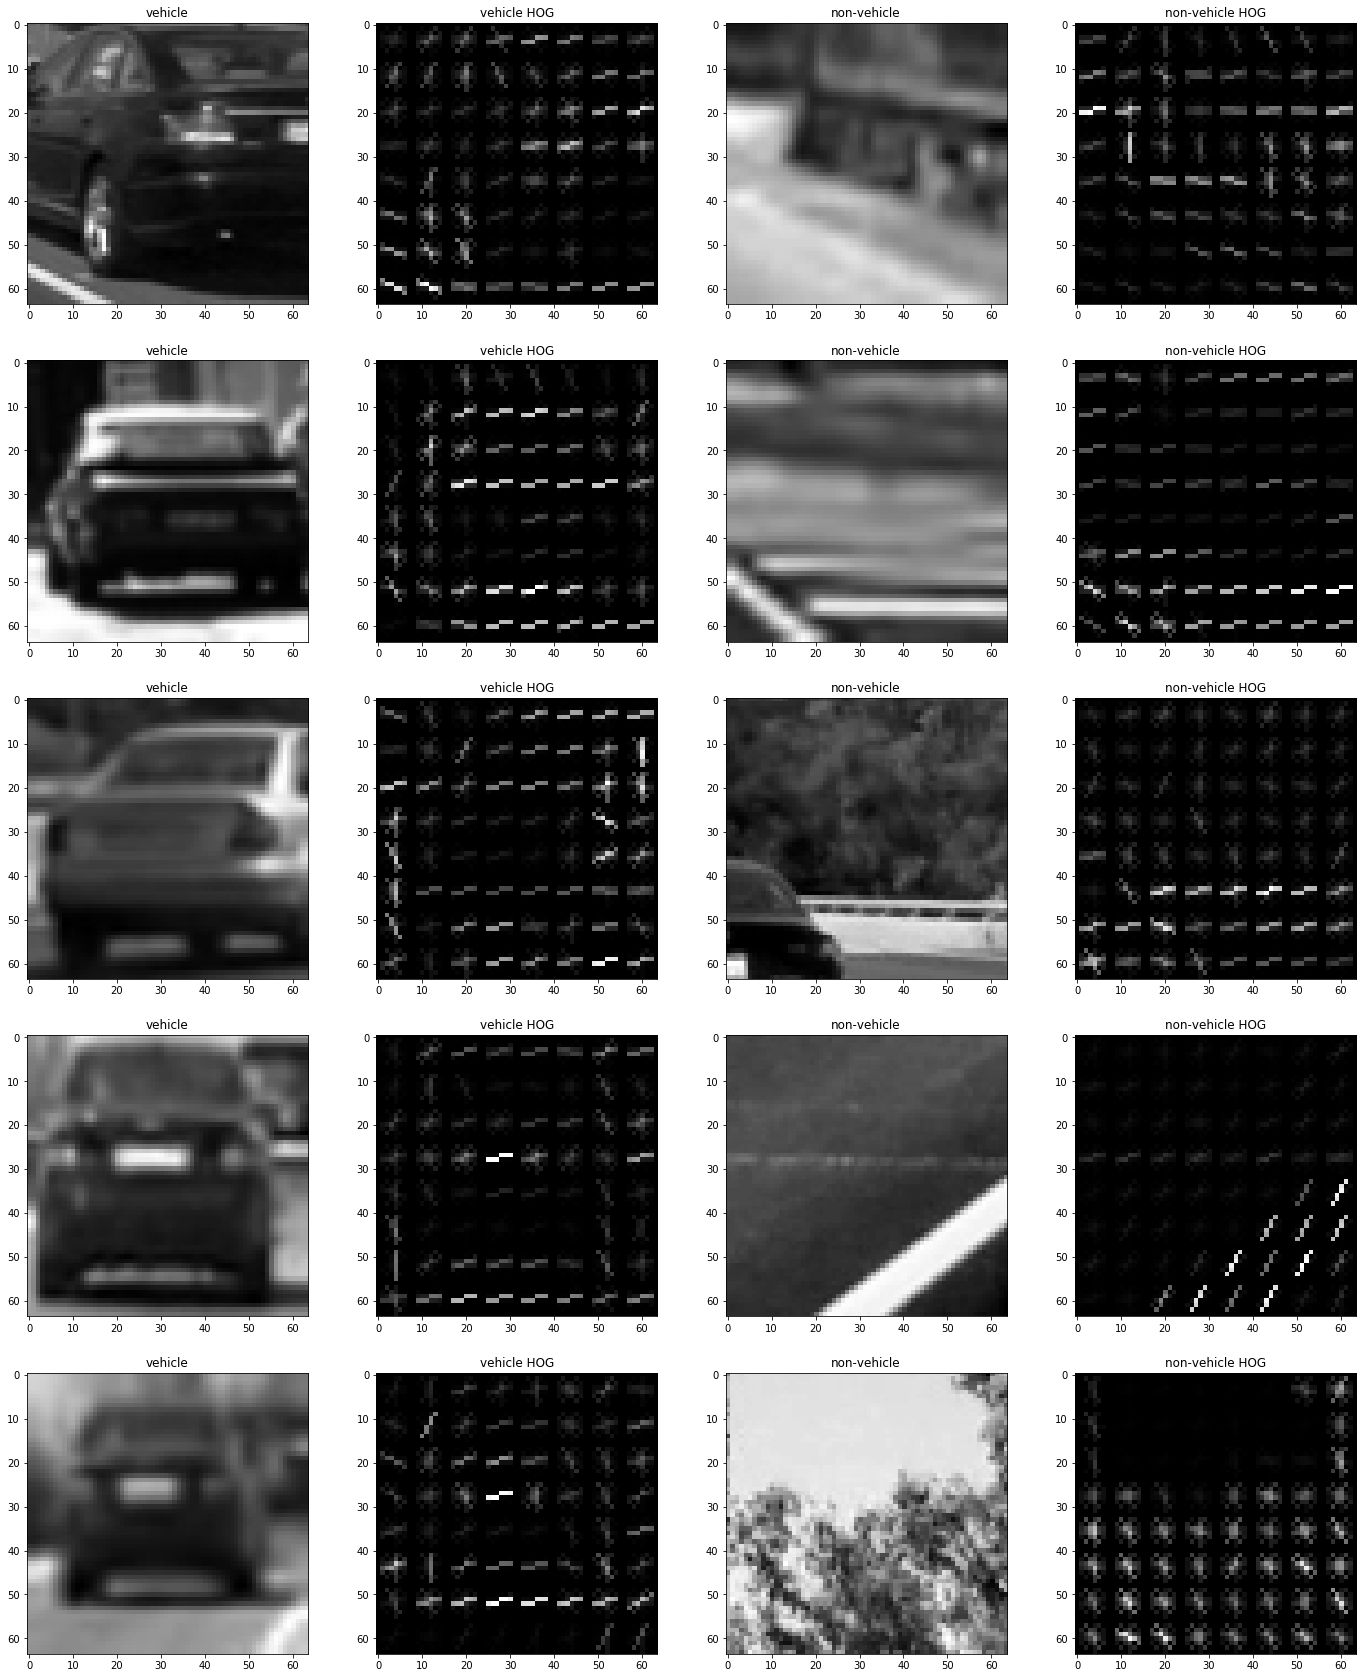

In [8]:
# 5 vehicle images from the labeled training set
v_images = glob.glob('./examples/vehicle_samples/*.png')
# 5 non-vehicle images from the labeled training set
nv_images = glob.glob('./examples/non_vehicle_samples/*.png')

plt.figure(figsize = (24,30))
for i in range(1,6):
    v_img = mpimg.imread(v_images[i-1])
    v_gray = cv2.cvtColor(v_img, cv2.COLOR_RGB2GRAY)
    vf,v_h = get_hog_features(v_gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    nv_img = mpimg.imread(nv_images[i-1])
    nv_gray = cv2.cvtColor(nv_img, cv2.COLOR_RGB2GRAY)
    nvf,nv_h = get_hog_features(nv_gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    plt.subplot(5,4,i*4-3)
    plt.title('vehicle', fontsize=12)
    plt.imshow(v_gray, cmap='gray')
    plt.subplot(5,4,i*4-2)
    plt.title('vehicle HOG', fontsize=12)
    plt.imshow(v_h, cmap='gray')
    plt.subplot(5,4,i*4-1)
    plt.title('non-vehicle', fontsize=12)
    plt.imshow(nv_gray, cmap='gray')
    plt.subplot(5,4,i*4)
    plt.title('non-vehicle HOG', fontsize=12)
    plt.imshow(nv_h, cmap='gray')
plt.show()

## Step 2. Append binned color features, histograms of color, to the HOG feature vector

In [9]:
images = glob.iglob('../training_data/vehicles/*/*.png')
cars = []
for image in images:
    cars.append(image)

images = glob.iglob('../training_data/non-vehicles/*/*.png')
notcars = []
for image in images:
    notcars.append(image)

print('The training data includes')
print('vehicle images: ' + str(len(cars)))
print('non-vehicle images: ' + str(len(notcars)))

The training data includes
vehicle images: 8792
non-vehicle images: 8968


In [10]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

## Step 3. Normalize the features and randomize a selection for training and testing

In [11]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


## Step 4. Train a classifier Linear SVM classifier

In [12]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

23.79 Seconds to train SVC...
Test Accuracy of SVC =  0.9873


## Step 5-a. Implement sliding-window technique

In [13]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))

    return window_list

In [14]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)

    return imcopy

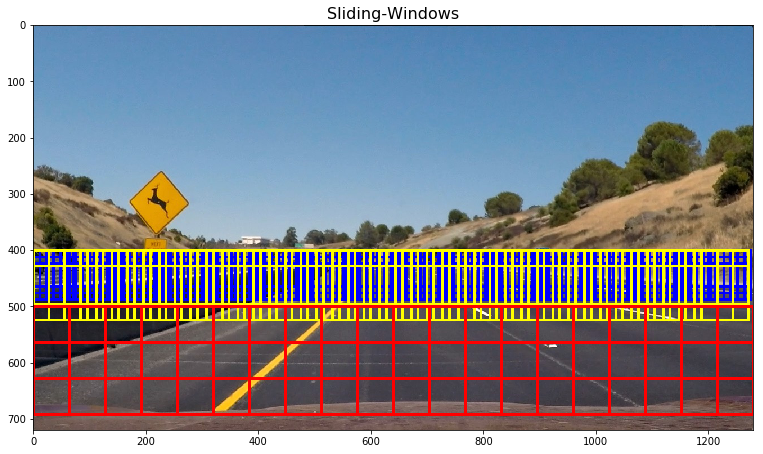

In [18]:
test_image = mpimg.imread('./test_images/test2.jpg')

# Create sliding-windows in different size
windows_sml = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[400,496], 
                        xy_window=(64, 64), xy_overlap=(0.8, 0.8))
windows_mid = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[400,544], 
                        xy_window=(96, 96), xy_overlap=(0.7, 0.7))
windows_big = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[500,692], 
                        xy_window=(128, 128), xy_overlap=(0.5, 0.5))

# Put all size windows in
windows = []
windows.extend(windows_sml)
windows.extend(windows_mid)
windows.extend(windows_big)

# Draw the examples
test_image = draw_boxes(test_image, windows_sml, color=(0, 0, 255), thick=3)
test_image = draw_boxes(test_image, windows_mid, color=(255, 255, 0), thick=3)
test_image = draw_boxes(test_image, windows_big, color=(255, 0, 0), thick=3)

f, (ax1) = plt.subplots(1, 1, figsize=(10, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Sliding-Windows', fontsize=16)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step 5-b. Use the trained classifier to search for vehicles in images

In [19]:
# Define a function to extract features from a single image window
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    

    img_features = []
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)

    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)

    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        img_features.append(hog_features)

    return np.concatenate(img_features)

In [20]:
# Define a function to be search vehicles by passing an image and the list of windows (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    # Create an empty list to receive positive detection windows
    on_windows = []
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict using the trained classifier
        prediction = clf.predict(test_features)
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)

    return on_windows  

#### Implement heatmap technique for vehicle searching

In [21]:
from scipy.ndimage.measurements import label

In [22]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap # Iterate through list of bboxes

In [23]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0

    return heatmap

In [24]:
def draw_labeled_bboxes(img, labels, strip = True):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 3)
    # Return the image
    return img

#### Combine the search windows and heatmaps on test images

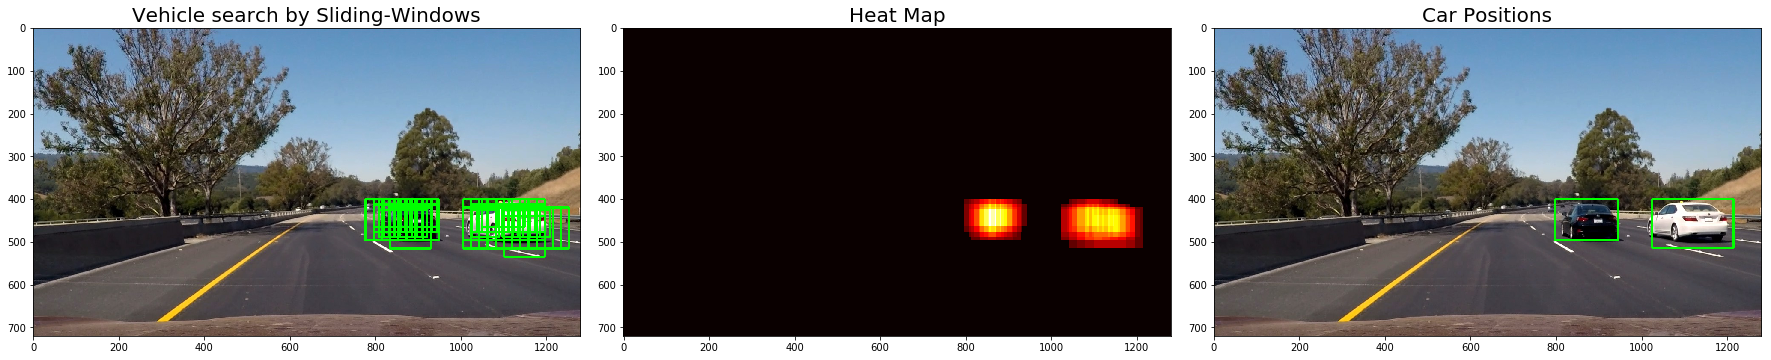

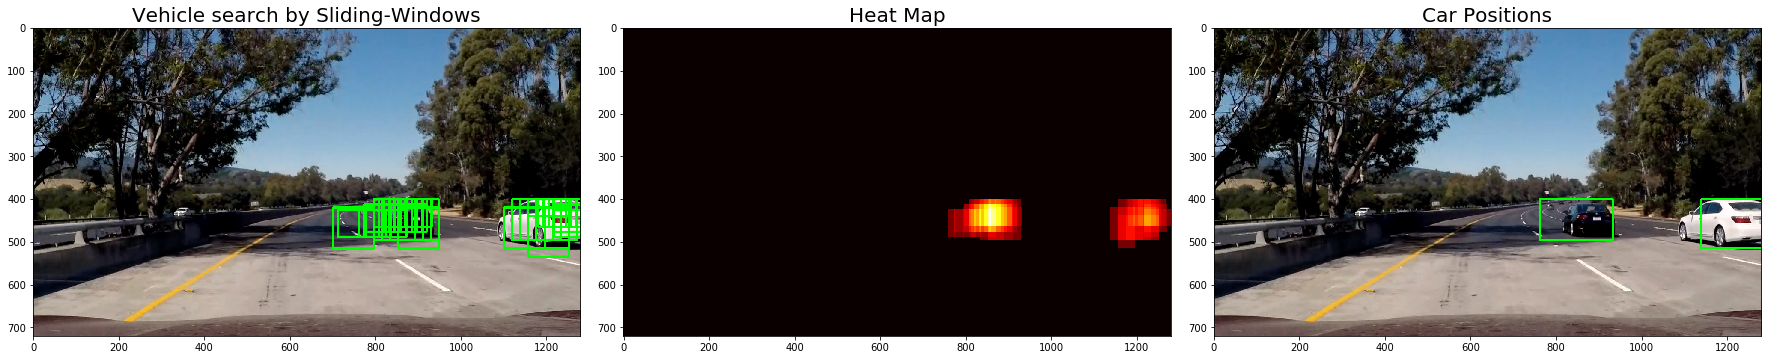

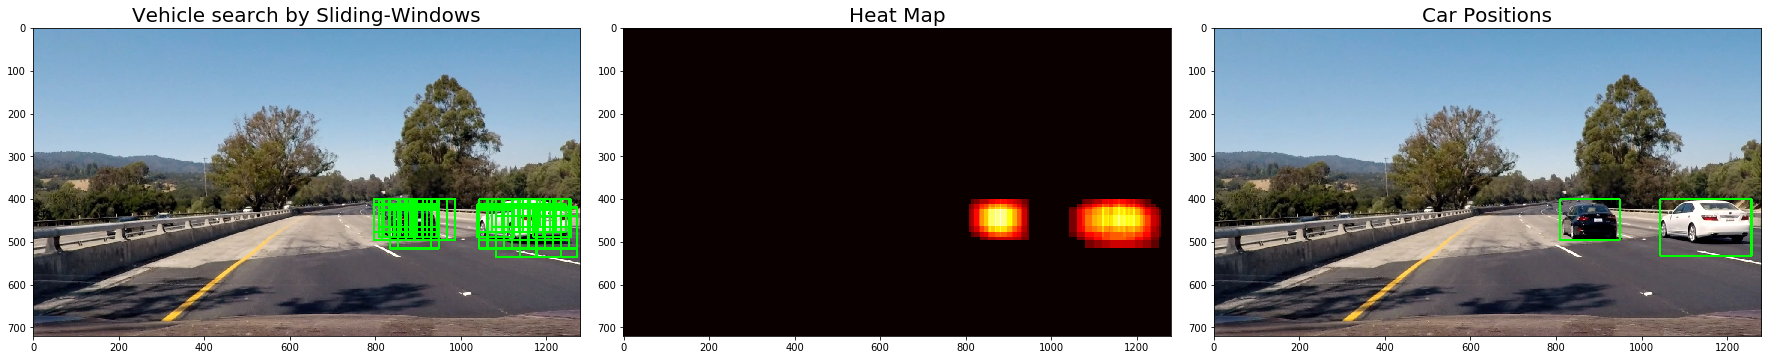

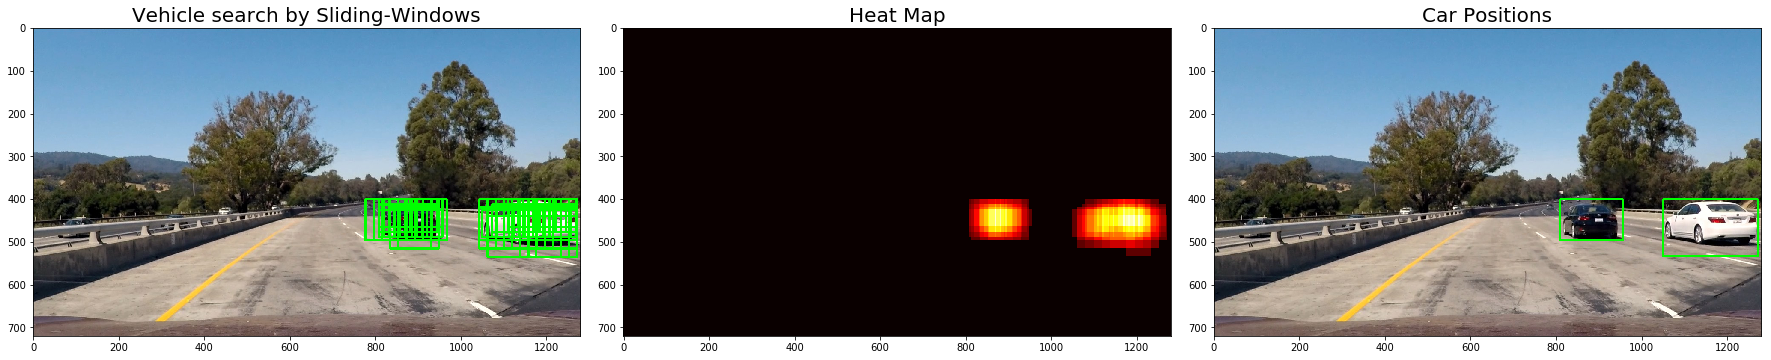

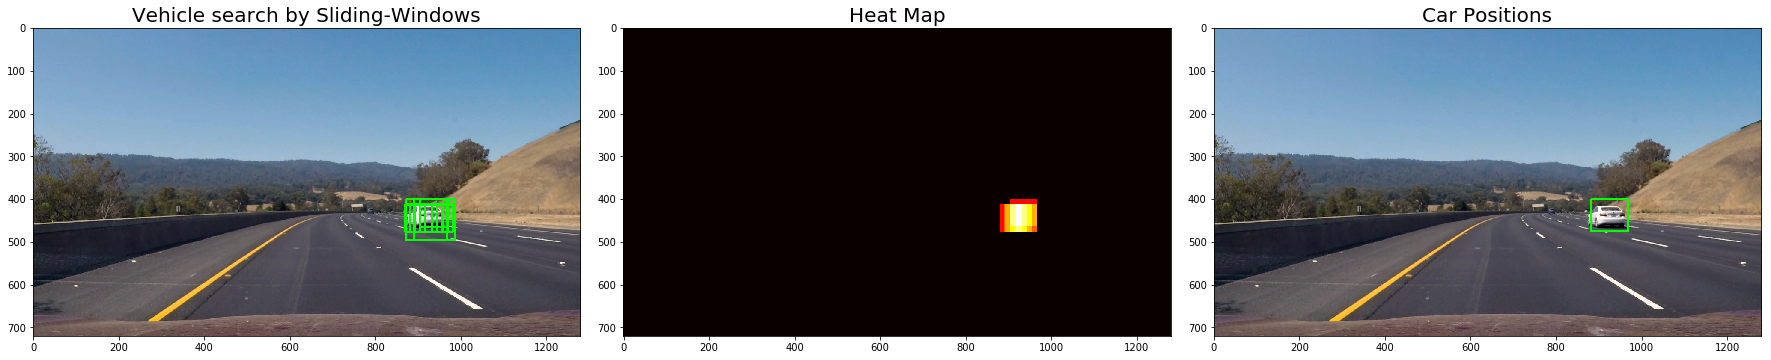

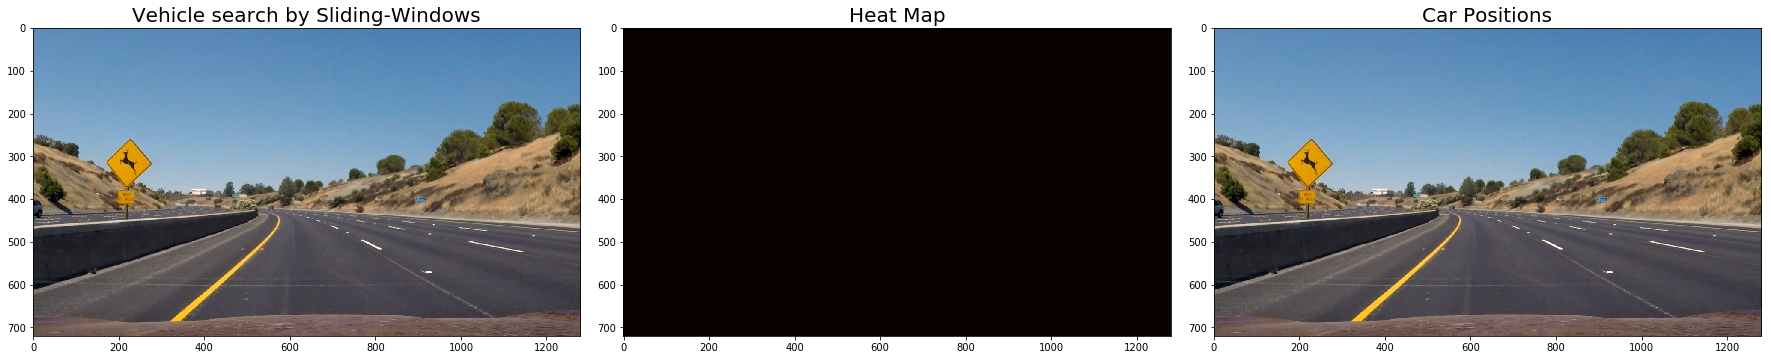

In [34]:
test_images = glob.glob('./test_images/*.jpg')

for img in test_images:
    image = mpimg.imread(img)
    draw_image = np.copy(image)
    heat_image = np.copy(image)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    image = image.astype(np.float32)/255 # read in .jpg images
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 255, 0), thick=3) 
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(heat_image, labels)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(window_img)
    ax1.set_title('Vehicle search by Sliding-Windows', fontsize=20)
    ax2.imshow(heatmap, cmap='hot')
    ax2.set_title('Heat Map', fontsize=20)
    ax3.imshow(draw_img)
    ax3.set_title('Car Positions', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step 6. Run the pipeline on a video stream

In [35]:
# Create a list to storage boxes flow
continue_windows = [] 

In [36]:
def box_process(draw_image, image, windows, threshold=0, apd=True, ofs=True):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)    
    heat = add_heat(heat, windows)
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    
    obj_boxes = []  
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))  
        
        if apd:
            obj_boxes.append(bbox)
            
        if ofs:
            bbox = ((bbox[0][0] - 5, bbox[0][1] - 3), (bbox[1][0] + 2, bbox[1][1] + 1))
            cv2.rectangle(draw_image, bbox[0], bbox[1], (0,255,0), 3)

    return obj_boxes, draw_image

In [37]:
# Create the pipeline
def pipeline(image):
    
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)  
        
    obj_boxes, draw_image = box_process(draw_image, image, hot_windows, threshold=2, apd=True, ofs=False)
        
    if len(continue_windows) == 10: # integrate box positions from last 10 frames
        continue_windows.pop(0)
            
    continue_windows.append(obj_boxes)
   
    smooth_windows = []    
    for one_window in continue_windows:
        smooth_windows.extend(one_window)
        
    obj_boxes, draw_image = box_process(draw_image, image, smooth_windows, threshold=6, apd=False, ofs=True)
    
    return draw_image

In [38]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [39]:
white_output = './project_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_output.mp4
[MoviePy] Writing video ./project_output.mp4


100%|█████████▉| 1260/1261 [31:20<00:01,  1.51s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_output.mp4 

CPU times: user 30min 56s, sys: 15.8 s, total: 31min 12s
Wall time: 31min 20s
